# Evolution of actors careers post-blockbuster in the film industry
How does a significant box office success impact an actor's subsequent choices and overall career path ?

##  Context

Analyze career trajectories of actors following their roles in high-grossing films using the CMU Movie Dataset

More specifically, explore the following research questions: 
- Does a high-grossing film consistently lead to **continued box office success** for its actors in their subsequent films?
- Is there a noticeable **change in genre or type of characters** portrayed by actors after a significant hit?
- What are the long-term career impacts on actors who have starred in blockbuster hits?

In [1]:
# External imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from collections import Counter
from helpers import parse_genres

## Observational study

In [2]:
# Retrieve stored dataframes from previous notebook
%store -r balanced_df
%store -r df_prepared
%store -r matched_df

In [3]:
# Keep only the matched actors
balanced_actors = balanced_df['name_actor']
df_movies_balanced = df_prepared[df_prepared['name_actor'].isin(balanced_actors)]

Now, we want to compare the carrer longevity

In [4]:
# Convert releaseDate to DateTime
df_movies_balanced['releaseDate'] = pd.to_datetime(df_movies_balanced['releaseDate'], errors='coerce')

# Calculate Last and First Apparence
career_start = df_movies_balanced.groupby('name_actor')['releaseDate'].min()
career_end = df_movies_balanced.groupby('name_actor')['releaseDate'].max()

career_duration = (career_end - career_start).dt.days / 365.25  # Convert days to years
career_duration_df = career_duration.reset_index()
career_duration_df.rename(columns={'releaseDate': 'career_length_in_years'}, inplace=True)


C:\Users\diego\AppData\Local\Temp\ipykernel_1228\4040368507.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies_balanced['releaseDate'] = pd.to_datetime(df_movies_balanced['releaseDate'], errors='coerce')


In [5]:
carrer_longevity_df = pd.merge(df_movies_balanced, career_duration_df, on='name_actor')



In [6]:
# Analysis
treatment_group = carrer_longevity_df[carrer_longevity_df['big_hit_actor'] == True]
control_group = carrer_longevity_df[carrer_longevity_df['big_hit_actor'] == False]

mean_career_length_treatment = treatment_group['career_length_in_years'].mean()
mean_career_length_control = control_group['career_length_in_years'].mean()

print(f'The mean carrer longevity of actors that played in a big hit is: {mean_career_length_treatment} (treatement group)')
print(f'The mean carrer longevity of actors that did not play in a big hit is: {mean_career_length_control} (control group)')


The mean carrer longevity of actors that played in a big hit is: 18.536683110133048 (treatement group)
The mean carrer longevity of actors that did not play in a big hit is: 15.452050468987197 (control group)


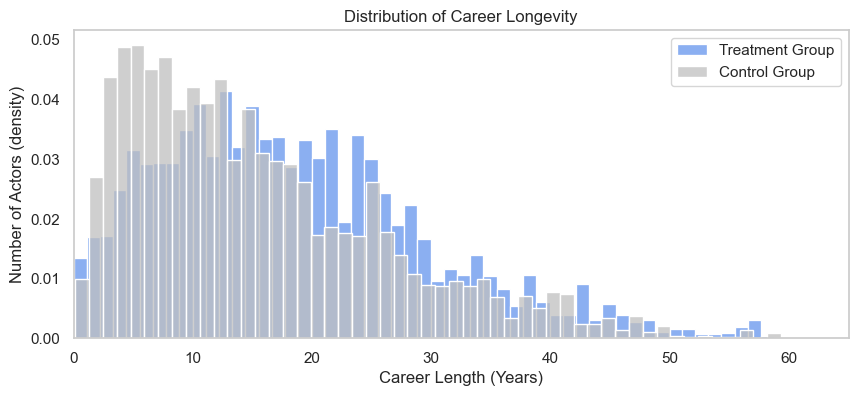

In [7]:
# Histogram

# Set the style
sns.set(style="whitegrid")

# Plot histograms
plt.figure(figsize=(10, 4))
plt.xlim([0, 65])
plt.grid(False)
sns.histplot(treatment_group['career_length_in_years'], color="cornflowerblue", label='Treatment Group', stat='density')
sns.histplot(control_group['career_length_in_years'], color="silver", label='Control Group', stat='density')

plt.title('Distribution of Career Longevity')
plt.xlabel('Career Length (Years)')
plt.ylabel('Number of Actors (density)')
plt.legend()
plt.show()

The control group appears to have more actors in the shorter career span categories (less than 10 years), whereas the treatment group has a more evenly distributed frequency across different career lengths. The treatment group has more actors with longer careers, indicated by the bars extending further to the right (beyond 30 years), compared to the control group. This suggests that actors who have been in a big hit may have longer-lasting careers.

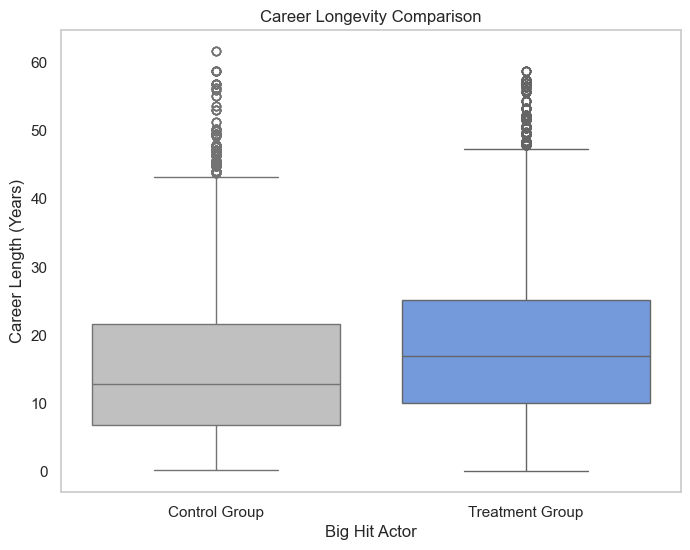

In [8]:
# Box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='big_hit_actor', y='career_length_in_years', data=carrer_longevity_df[~carrer_longevity_df.big_hit_actor], color='silver')
sns.boxplot(x='big_hit_actor', y='career_length_in_years', data=carrer_longevity_df[carrer_longevity_df.big_hit_actor], color='cornflowerblue')

plt.grid(False)
plt.title('Career Longevity Comparison')
plt.xlabel('Big Hit Actor')
plt.ylabel('Career Length (Years)')
plt.xticks([0, 1], ['Control Group', 'Treatment Group'])
plt.show()

Comparing the two boxes, we can see that not only is the median of the treatment group higher (indicating longer average career lengths), but the box and whiskers are also generally higher on the scale. This implies that actors in the treatment group not only have a tendency towards longer careers on average but also include more actors with very long careers.

Next, we will look to the number of unique movieIDs associated with each actor to see if actors in big hits tend to appear in more movies overall

In [9]:

# Calculate the average number of movies for the treatment group
average_movies_treatment = treatment_group['movie_count'].mean()

# Calculate the average number of movies for the control group
average_movies_control = control_group['movie_count'].mean()

print(f'Average number of movies for actors in big hits: {average_movies_treatment}')
print(f'Average number of movies for actors not in big hits: {average_movies_control}')


Average number of movies for actors in big hits: 11.610159362549801
Average number of movies for actors not in big hits: 7.098966690199602


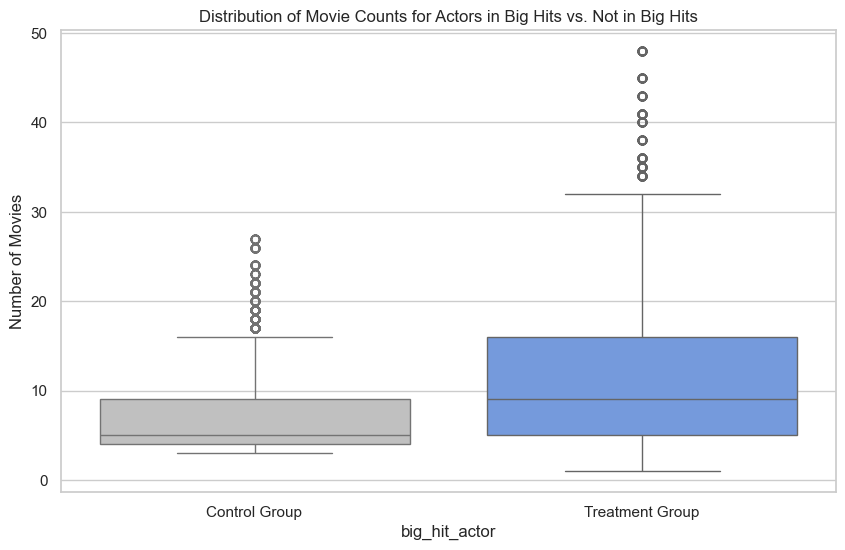

In [10]:
averages = [average_movies_control, average_movies_treatment]
group_names = ['Control Group', 'Treatment Group']

# Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='big_hit_actor', y='movie_count', data=carrer_longevity_df[~carrer_longevity_df.big_hit_actor], color='silver')
sns.boxplot(x='big_hit_actor', y='movie_count', data=carrer_longevity_df[carrer_longevity_df.big_hit_actor], color='cornflowerblue')
plt.xticks([0, 1], ['Control Group', 'Treatment Group'])
plt.ylabel('Number of Movies')
plt.title('Distribution of Movie Counts for Actors in Big Hits vs. Not in Big Hits')
plt.show()

The treatment group's median is higher than the control group's median, indicating that actors who have played in big hits tend to appear in more movies. 

The treatment group's upper whisker extends farther than the control group's, suggesting that some actors in the treatment group have appeared in a very high number of movies

The treatment group not only has a higher median but also a wider range of movie counts, suggesting that being in a big hit could be associated with a larger number of movie appearances. However, the presence of outliers indicates that there are exceptions to this trend

We want how long it takes to achieve a big hit for the treatment group

In [11]:
career_start = carrer_longevity_df.groupby('name_actor')['releaseDate'].min().dt.year

career_start_df = career_start.reset_index()
career_start_df.columns = ['name_actor', 'career_start_year']

In [12]:
merged_df = pd.merge(carrer_longevity_df, career_start_df, on='name_actor')


In [13]:
merged_df['ethnicity'].isna().sum() / len(merged_df)

0.6103866969518522

In [14]:
treatment_group= merged_df[merged_df['big_hit_actor']==True]

treatment_group['time_to_first_big_hit'] = treatment_group['releaseDate_first_big_hit'].dt.year - treatment_group['career_start_year']

print(f"Time to achieve a big hit for a big hit actor: {treatment_group['time_to_first_big_hit'].mean()}")


Time to achieve a big hit for a big hit actor: 5.8095617529880474


C:\Users\diego\AppData\Local\Temp\ipykernel_1228\1179288889.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treatment_group['time_to_first_big_hit'] = treatment_group['releaseDate_first_big_hit'].dt.year - treatment_group['career_start_year']


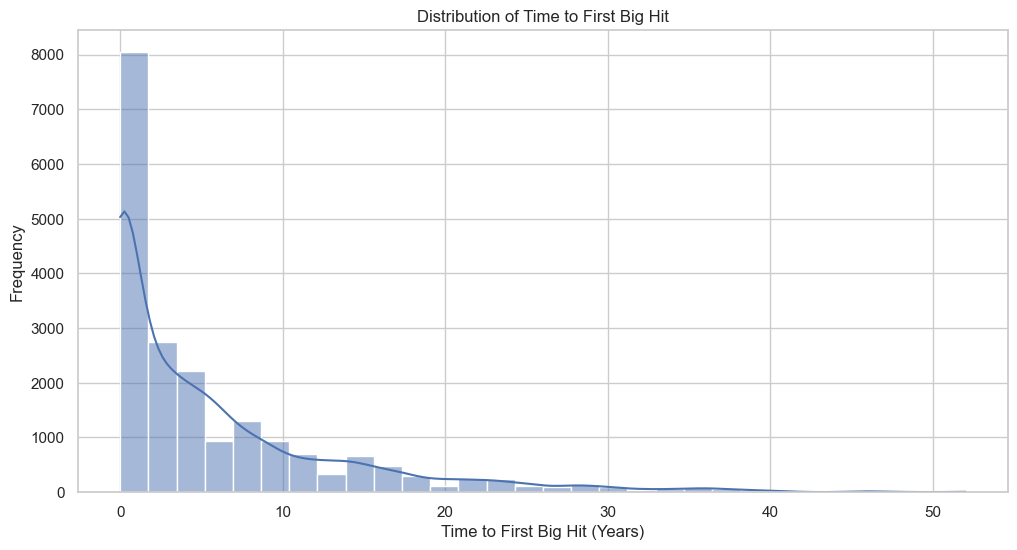

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution of time to first big hit
plt.figure(figsize=(12, 6))
sns.histplot(treatment_group['time_to_first_big_hit'], bins=30, kde=True)
plt.title('Distribution of Time to First Big Hit')
plt.xlabel('Time to First Big Hit (Years)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Career post-big-hit anaylsis

It is interesting to look at the evolution of the career of actors after their first big-hit to see if we can notice any change with their career pre-big-hit or with the career of an actor that did not play in a big hit. 

We want compare the before/after big-hit career of actors in the treatment group with the ones in the control group. To do so we have to define an event for the actors in the control group that will be used as reference to set the before/after career of those actors (since they did not play in any big hit movie). We decided to attribute a mock-up 'first big hit' to actors in the control group that corresponds to the movie number (ordered in chronological order) of first big hit of their respective matched treatment group actor. So for example, Lou Taylor Pucci is in the control group since he did not play in any big-hit movies, he was matched with Leonardo DiCaprio who is in the treatment group. Leonardo DiCaprio had his first big hit after playing in 4 movies, it's 5th movie was his first big-hit. Following this, we set the mock-up first big-hit of Lou Taylor Pucci to be his 5th movie. In a sense this 'nth' movie represents the most likely movie for the first big-hit of control group actors (if they had one).

First we want to use the matched dataframe to create a new column on our working dataframe. This column will contain, for each actor, the name of the actor that has been matched with them. 

In [33]:
# Keep only interesting columns for subsequent analysis
col = ['movieID', 'name_movie', 'releaseDate', 'genres',  'revenue', 'success', 'averageRating', 'is_big_hit', 'name_actor',
       'birth', 'big_hit_actor', 'movie_count_before_hit']
df_career_analysis = df_movies_balanced[col].copy()

In [17]:
# Remove duplicate rows (actors that had multiple roles in the same movie)
# df_career_analysis = df_career_analysis.drop_duplicates()   ---> done in matching (?)

In [34]:
# Keep only name columns from the matched dataframe
matched_df = matched_df[['name_actor_control', 'name_actor_treat']]

# Create new column with the name of the matched actor (do this for treatment and control group):
# First populate our dataframe with the mached treatment actor names for the control group
df_career_analysis = pd.merge(df_career_analysis, matched_df, left_on='name_actor', right_on='name_actor_control', how='left')
df_career_analysis = df_career_analysis.drop(labels='name_actor_control', axis=1)
# Do the same for the treatment group
df_career_analysis = pd.merge(df_career_analysis, matched_df, left_on='name_actor', right_on='name_actor_treat', how='left', suffixes=('', '_merge'))
df_career_analysis = df_career_analysis.drop(labels='name_actor_treat_merge', axis=1)

# Merge the two columns to form only one (matched_name)
df_career_analysis['matched_name'] = df_career_analysis['name_actor_treat'].combine_first(df_career_analysis['name_actor_control'])
df_career_analysis = df_career_analysis.drop(labels=['name_actor_control', 'name_actor_treat'], axis=1)

Then we want to attribute to each control actor the same 'movie_count_before_hit' as the actor they have been matched with.

In [35]:
# Merge our dataframe (df_career_analysis) with a version of itself (only one row for each acotrs) based on 'matched_name'
df_for_merge = df_career_analysis.drop_duplicates(subset='name_actor')
merged_df = pd.merge(df_career_analysis, df_for_merge[['name_actor', 'movie_count_before_hit']],
                     left_on='matched_name',
                     right_on='name_actor',
                     how='left',
                     suffixes=('', '_matched'))

# Fill missing values in 'movie_count_before_hit' with values from the matched actor
df_career_analysis['movie_count_before_hit'] = df_career_analysis['movie_count_before_hit'].combine_first(merged_df['movie_count_before_hit_matched'])

Now let's look at the genres of the different movies actors played in. We first have to convert the genre column from strings to bags of words. For this we first use the function we defined in helpers called parse_genres which safely parses the genres string and extracts genre names. We then use teh Counter function from collections library to finally end up with bags of words.

In [36]:
# Use the parse_genres function defined in helpers file to parse strings and extract genre names
df_career_analysis['parsed_genres'] = df_career_analysis['genres'].apply(parse_genres)

# Compute the number of movies that do not have any genre value to assess the loss caused by this operation
nb_movies_lost = df_career_analysis[df_career_analysis['parsed_genres'].isna()].movieID.nunique()
# Remove rows that do not have information on the genres of the movie
df_career_analysis = df_career_analysis.dropna(subset='parsed_genres')

# For the gernes column, replace the list by a bag of words using the Counter function
df_career_analysis['genres'] = df_career_analysis.parsed_genres.apply(lambda x: Counter(x))
# Get rid of unwanted column
df_career_analysis = df_career_analysis.drop(labels='parsed_genres', axis=1)

# Print the number of movies lost
print(f'The number of movies that we lost because they did not have information on genre is: {nb_movies_lost}.')

The number of movies that we lost because they did not have information on genre is: 1.


We only lost a single movie out hundreds so we will ignore this loss and carry on with our analysis.

Now, before going further, we will arrange the movies in a chronological order and assign a number representing the respective position (in the timeline) with respect to the first big-hit movie. This number is named 'n': n<0 if the movie was released before the first big-hit movie, n=0 is the movie is the first big-hit movie and n>0 if the movie was released after the first big-hit movie.

In [37]:
# Sort by actor name and order by release date  (TODO sort also on sucess for those actors that have different movies with same releasedate)
df_career_analysis = df_career_analysis.sort_values(by=['name_actor', 'releaseDate', 'success']).reset_index(drop=True)

# Add new column with number giving distance in number of movies to first big hit (n = 0 for year of first big hit)
def center_on_first_hit(row, df):
    # Function that return the position of the movie with respect to the fir big-hit (in chronological order)
    
    # Get the relative index of the row that is passed to the function with respect to the df
    n_actual = df[(df.releaseDate == row.releaseDate) & (df.success == row.success)].index.values[0]-df.index.values[0]
    # Get the number of movies before the first big-hit
    n_big_hit = row.movie_count_before_hit

    return n_actual - n_big_hit

# Group by actor names and apply the center_on_first_hit function to comptue 'n'
grp = df_career_analysis.groupby('name_actor')
df_career_analysis['n'] = grp.apply(lambda x: x.apply(lambda row: center_on_first_hit(row, x), axis=1)).reset_index(drop=True)

# Get rid of unwanted columns for upcoming analysis
#df_career_analysis = df_career_analysis.drop(labels='movie_count_before_hit', axis=1)

df_career_analysis

,movieID,name_movie,releaseDate,genres,revenue,success,averageRating,is_big_hit,name_actor,birth,big_hit_actor,movie_count_before_hit,matched_name,n
0,/m/07s114,Get Rich or Die Tryin',2005-11-09,"{'Crime Fiction': 1, 'Hip hop movies': 1, 'Com...",4.644253e+07,2.507897e+08,5.4,False,50 Cent,1975-07-06,False,2.0,Gabriel Casseus,-2.0
1,/m/0f9x7r,Home of the Brave,2006-12-15,"{'Drama': 1, 'War film': 1}",4.996200e+05,2.797872e+06,5.6,False,50 Cent,1975-07-06,False,2.0,Gabriel Casseus,-1.0
2,/m/02r6fhw,Righteous Kill,2008-09-10,"{'Thriller': 1, 'Crime Fiction': 1, 'Psycholog...",7.674720e+07,4.604832e+08,6.0,False,50 Cent,1975-07-06,False,2.0,Gabriel Casseus,0.0
3,/m/07k4g72,Twelve,2010-08-05,"{'Crime Fiction': 1, 'Drama': 1, 'Film adaptat...",2.566717e+06,1.437362e+07,5.6,False,50 Cent,1975-07-06,False,2.0,Gabriel Casseus,1.0
4,/m/05zntwr,Morning Glory,2010-11-10,"{'Romance Film': 1, 'Drama': 1, 'Comedy': 1}",5.878518e+07,3.821037e+08,6.5,False,50 Cent,1975-07-06,False,2.0,Gabriel Casseus,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35651,/m/0337wr,Carlito's Way,1993-11-10,"{'Crime Fiction': 1, 'Gangster Film': 1, 'Dram...",6.384832e+07,5.044017e+08,7.9,False,Ángel Salazar,1956-03-02,True,0.0,Will Oldham,1.0
35652,/m/047vldj,The Limits of Control,2009-05-01,"{'Thriller': 1, 'Crime Fiction': 1, 'Japanese ...",1.395030e+06,8.649186e+06,6.2,False,Óscar Jaenada,1975-05-04,True,2.0,Zachary Booth,-2.0
35653,/m/0b6l1st,The Losers,2010-04-22,"{'Thriller': 1, 'Crime Fiction': 1, 'Superhero...",2.937972e+07,1.821543e+08,6.2,False,Óscar Jaenada,1975-05-04,True,2.0,Zachary Booth,-1.0
35654,/m/09v8clw,Pirates of the Caribbean: On Stranger Tides,2011-05-07,"{'Swashbuckler films': 1, 'Adventure': 1, 'Cos...",1.043872e+09,6.889554e+09,6.6,True,Óscar Jaenada,1975-05-04,True,2.0,Zachary Booth,0.0


Now we want to compare different genre bag of words. To do so we must define a similarity function to use. The different movies have different level of genre description; some are short bag of words (e.g. {Drama: 1}), some are medium-length bag of words (e.g. {Drama: 1, Romance: 1}), and some are longer bag of words (e.g. {Drama: 1, Horror: 1, War film: 1}). But all three previous bag of words should have the same similarity since they all have only one genre in common and nothing else. Following this reasoning we decided to compute the similarity by simply counting the number of words that are the same in the two bag of words that we are comparing, without penalizing their length.

In [38]:
# Function to compute the similarity between two bag of words
def dotproduct_similarity(c1, c2):
    # This function simply retruns the dotproduct between the two bag of words (i.e. counts the number of words that are the same)
    all_genres = set(c1).union(c2)
    dotproduct = sum(c1.get(g, 0) * c2.get(g, 0) for g in all_genres)

    return dotproduct

TODO: describe what we decided to compare with what

In [39]:
df_n_0 = df_career_analysis[df_career_analysis.n == 0]
list_name_ok = df_n_0.name_actor.unique()
df_career_analysis[~df_career_analysis.name_actor.isin(list_name_ok)].head(50)

,movieID,name_movie,releaseDate,genres,revenue,success,averageRating,is_big_hit,name_actor,birth,big_hit_actor,movie_count_before_hit,matched_name,n
31332,/m/0csf__,Tooth Fairy,2010-01-14,"{'Family Film': 1, 'Fantasy Comedy': 1, 'Fanta...",112462508.0,5.623125e+08,5.0,False,Seth MacFarlane,1973-10-26,True,2.0,Domenick Lombardozzi,-2.0
31333,/m/0gj9tn5,Ted,2012-06-29,{'Comedy': 1},488965740.0,3.373864e+09,6.9,True,Seth MacFarlane,1973-10-26,True,2.0,Domenick Lombardozzi,-1.0


In [40]:
# TODO find how to deal with genres = {} (empty) e.g. with Seth MacFarlane
df_career_analysis = df_career_analysis[~(df_career_analysis.name_actor == 'Seth MacFarlane')]

In [41]:
def calculate_similarity_prev_movie(df, row):
    row_index = df[(df.movieID == row.movieID)].index[0]-df.index[0]
    
    if row_index == 0:
        return None
    
    prev = df.iloc[row_index-1].genres
    current = row.genres

    return dotproduct_similarity(prev, current)

def calculate_similarity_two_prev_movie(df, row):
    row_index = df[(df.movieID == row.movieID)].index[0]-df.index[0]
    
    if row_index == 0:
        return None

    prev_1 = df.iloc[row_index-1].genres
    current = row.genres
    
    if row_index == 1:
        return dotproduct_similarity(prev_1, current)
    
    prev_2 = df.iloc[row_index-2].genres

    return 0.5*(dotproduct_similarity(prev_1, current)+dotproduct_similarity(prev_2, current))

def calculate_similarity_big_hit(df, row):   
    row_index = df[(df.movieID == row.movieID)].index[0]-df.index[0]
    
    # This is to have similarity with the first big hit
    prev = df[df.n==0].genres.values[0]
    current = row.genres

    return dotproduct_similarity(prev, current)

grp = df_career_analysis.groupby('name_actor')
df_career_analysis['similarity_prev_movie'] = grp.apply(lambda x: x.apply(
    lambda row: calculate_similarity_prev_movie(x, row), axis=1)).reset_index(drop=True)
df_career_analysis['similarity_two_prev_movie'] = grp.apply(lambda x: x.apply(
    lambda row: calculate_similarity_two_prev_movie(x, row), axis=1)).reset_index(drop=True)
df_career_analysis['similarity_big_hit'] = grp.apply(lambda x: x.apply(
    lambda row: calculate_similarity_big_hit(x, row), axis=1)).reset_index(drop=True)

C:\Users\diego\AppData\Local\Temp\ipykernel_1228\411119340.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_career_analysis['similarity_prev_movie'] = grp.apply(lambda x: x.apply(
C:\Users\diego\AppData\Local\Temp\ipykernel_1228\411119340.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_career_analysis['similarity_two_prev_movie'] = grp.apply(lambda x: x.apply(
C:\Users\diego\AppData\Local\Temp\ipykernel_1228\411119340.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [42]:
# Get the mean among all actors of mean similarity for each year n
treat = df_career_analysis[df_career_analysis.big_hit_actor]
ctrl = df_career_analysis[~df_career_analysis.big_hit_actor]

# Get the number of actors we have for each year n
nb_of_actors_for_n_treat = treat.groupby('n')['name_actor'].count()
nb_of_actors_for_n_ctrl = ctrl.groupby('n')['name_actor'].count()

# Define the indexes we will keep where the number obf actors is representative enough (how much is representative enough?? 800? 1000?)
to_plot_indexes_treat = nb_of_actors_for_n_treat[nb_of_actors_for_n_treat.values>=1000].index
to_plot_indexes_ctrl = nb_of_actors_for_n_ctrl[nb_of_actors_for_n_ctrl.values>=1000].index

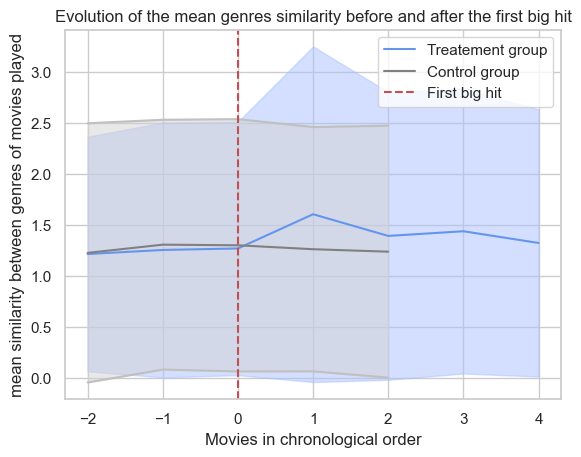

In [43]:
to_plot_treat = treat.groupby('n').similarity_prev_movie.mean()[to_plot_indexes_treat].astype(float)
to_plot_ctrl = ctrl.groupby('n').similarity_prev_movie.mean()[to_plot_indexes_ctrl].astype(float)

std_treat = treat.groupby('n')['similarity_prev_movie'].std()[to_plot_indexes_treat]
std_ctrl = ctrl.groupby('n')['similarity_prev_movie'].std()[to_plot_indexes_ctrl]

plt.fill_between(to_plot_treat.index, to_plot_treat-std_treat, to_plot_treat+std_treat, alpha = 0.5, color = (0.67, 0.757, 1))
plt.fill_between(to_plot_ctrl.index, to_plot_ctrl - std_ctrl, to_plot_ctrl + std_ctrl, alpha = 0.5, color =  'lightgrey')
plt.plot((to_plot_ctrl - std_ctrl), color='silver')
plt.plot((to_plot_ctrl + std_ctrl), color='silver')

plt.plot(to_plot_treat, label = 'Treatement group', color='cornflowerblue')
plt.plot(to_plot_ctrl, label = 'Control group', color='grey')

plt.axvline(0, color='r', label='First big hit', linestyle ='--')
plt.title('Evolution of the mean genres similarity before and after the first big hit')
plt.xlabel('Movies in chronological order')
plt.ylabel('mean similarity between genres of movies played')
plt.legend()

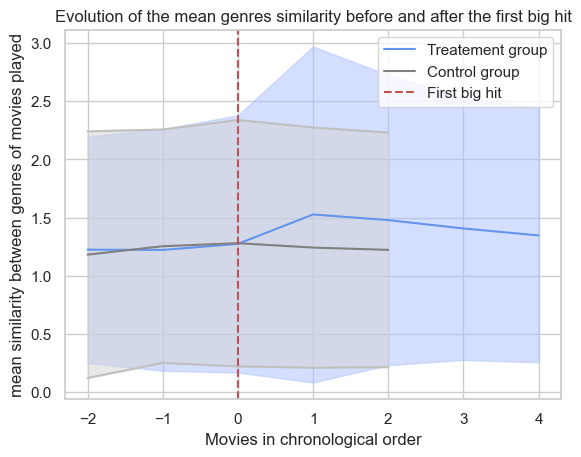

In [44]:
to_plot_treat = treat.groupby('n').similarity_two_prev_movie.mean()[to_plot_indexes_treat].astype(float)
to_plot_ctrl = ctrl.groupby('n').similarity_two_prev_movie.mean()[to_plot_indexes_ctrl].astype(float)

std_treat = treat.groupby('n')['similarity_two_prev_movie'].std()[to_plot_indexes_treat]
std_ctrl = ctrl.groupby('n')['similarity_two_prev_movie'].std()[to_plot_indexes_ctrl]

plt.fill_between(to_plot_treat.index, to_plot_treat-std_treat, to_plot_treat+std_treat, alpha = 0.5, color = (0.67, 0.757, 1))
plt.fill_between(to_plot_ctrl.index, to_plot_ctrl - std_ctrl, to_plot_ctrl + std_ctrl, alpha = 0.5, color =  'lightgrey')
plt.plot((to_plot_ctrl - std_ctrl), color='silver')
plt.plot((to_plot_ctrl + std_ctrl), color='silver')

plt.plot(to_plot_treat, label = 'Treatement group', color='cornflowerblue')
plt.plot(to_plot_ctrl, label = 'Control group', color='grey')

plt.axvline(0, color='r', label='First big hit', linestyle ='--')
plt.title('Evolution of the mean genres similarity before and after the first big hit')
plt.xlabel('Movies in chronological order')
plt.ylabel('mean similarity between genres of movies played')
plt.legend()

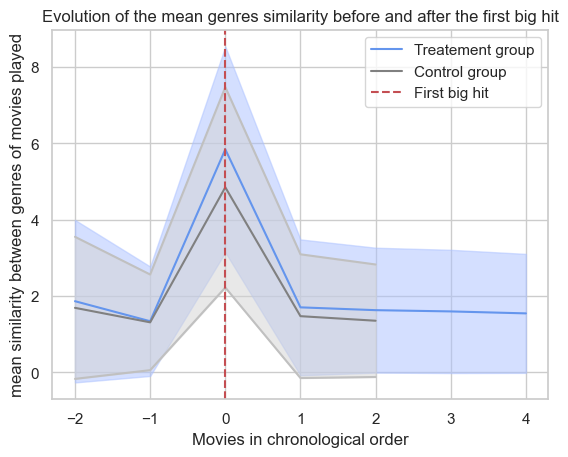

In [45]:
to_plot_treat = treat.groupby('n').similarity_big_hit.mean()[to_plot_indexes_treat].astype(float)
to_plot_ctrl = ctrl.groupby('n').similarity_big_hit.mean()[to_plot_indexes_ctrl].astype(float)

std_treat = treat.groupby('n')['similarity_big_hit'].std()[to_plot_indexes_treat]
std_ctrl = ctrl.groupby('n')['similarity_big_hit'].std()[to_plot_indexes_ctrl]

plt.fill_between(to_plot_treat.index, to_plot_treat-std_treat, to_plot_treat+std_treat, alpha = 0.5, color = (0.67, 0.757, 1))
plt.fill_between(to_plot_ctrl.index, to_plot_ctrl - std_ctrl, to_plot_ctrl + std_ctrl, alpha = 0.5, color =  'lightgrey')
plt.plot((to_plot_ctrl - std_ctrl), color='silver')
plt.plot((to_plot_ctrl + std_ctrl), color='silver')

plt.plot(to_plot_treat, label = 'Treatement group', color='cornflowerblue')
plt.plot(to_plot_ctrl, label = 'Control group', color='grey')

plt.axvline(0, color='r', label='First big hit', linestyle ='--')
plt.title('Evolution of the mean genres similarity before and after the first big hit')
plt.xlabel('Movies in chronological order')
plt.ylabel('mean similarity between genres of movies played')
plt.legend()

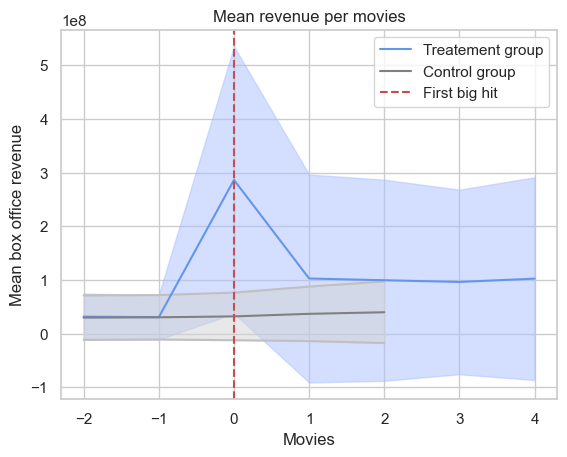

In [46]:
to_plot_treat = treat.groupby('n')['revenue'].mean()[to_plot_indexes_treat]
to_plot_ctrl = ctrl.groupby('n')['revenue'].mean()[to_plot_indexes_ctrl]

std_treat = treat.groupby('n')['revenue'].std()[to_plot_indexes_treat]
std_ctrl = ctrl.groupby('n')['revenue'].std()[to_plot_indexes_ctrl]

plt.fill_between(to_plot_treat.index, to_plot_treat-std_treat, to_plot_treat+std_treat, alpha = 0.5, color = (0.67, 0.757, 1))
plt.fill_between(to_plot_ctrl.index, to_plot_ctrl - std_ctrl, to_plot_ctrl + std_ctrl, alpha = 0.5, color =  'lightgrey')

plt.plot((to_plot_ctrl - std_ctrl), color='silver')
plt.plot((to_plot_ctrl + std_ctrl), color='silver')

plt.plot(to_plot_treat, label = 'Treatement group', color='cornflowerblue')
plt.plot(to_plot_ctrl, label = 'Control group', color='grey')


plt.axvline(x=0, color='r', label = 'First big hit', linestyle ='--')
plt.title('Mean revenue per movies')
plt.xlabel('Movies')
plt.ylabel('Mean box office revenue')
plt.legend()
plt.show()

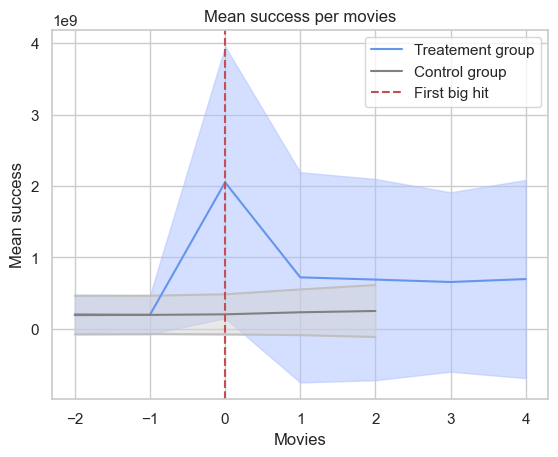

In [47]:
to_plot_treat = treat.groupby('n')['success'].mean()[to_plot_indexes_treat]
to_plot_ctrl = ctrl.groupby('n')['success'].mean()[to_plot_indexes_ctrl]

std_treat = treat.groupby('n')['success'].std()[to_plot_indexes_treat]
std_ctrl = ctrl.groupby('n')['success'].std()[to_plot_indexes_ctrl]

plt.fill_between(to_plot_treat.index, to_plot_treat-std_treat, to_plot_treat+std_treat, alpha = 0.5, color = (0.67, 0.757, 1))
plt.fill_between(to_plot_ctrl.index, to_plot_ctrl - std_ctrl, to_plot_ctrl + std_ctrl, alpha = 0.5, color =  'lightgrey')

plt.plot((to_plot_ctrl - std_ctrl), color='silver')
plt.plot((to_plot_ctrl + std_ctrl), color='silver')

plt.plot(to_plot_treat, label = 'Treatement group', color='cornflowerblue')
plt.plot(to_plot_ctrl, label = 'Control group', color='grey')

plt.axvline(x=0, color='r', label = 'First big hit', linestyle ='--')
plt.title('Mean success per movies')
plt.xlabel('Movies')
plt.ylabel('Mean success')
plt.legend()
plt.show()

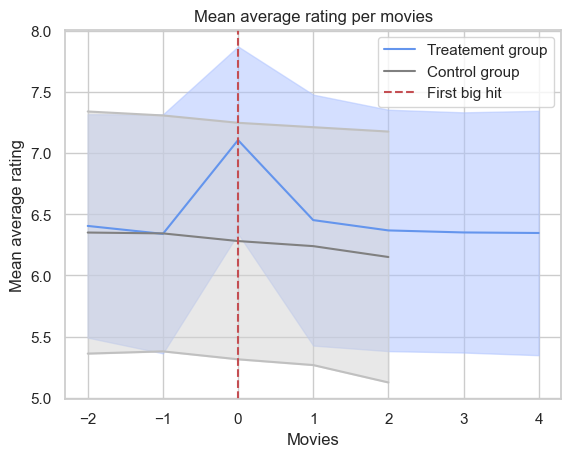

In [48]:
to_plot_treat = treat.groupby('n')['averageRating'].mean()[to_plot_indexes_treat]
to_plot_ctrl = ctrl.groupby('n')['averageRating'].mean()[to_plot_indexes_ctrl]

std_treat = treat.groupby('n')['averageRating'].std()[to_plot_indexes_treat]
std_ctrl = ctrl.groupby('n')['averageRating'].std()[to_plot_indexes_ctrl]

plt.fill_between(to_plot_treat.index, to_plot_treat-std_treat, to_plot_treat+std_treat, alpha = 0.5, color = (0.67, 0.757, 1))
plt.fill_between(to_plot_ctrl.index, to_plot_ctrl - std_ctrl, to_plot_ctrl + std_ctrl, alpha = 0.5, color =  'lightgrey')

plt.plot((to_plot_ctrl - std_ctrl), color='silver')
plt.plot((to_plot_ctrl + std_ctrl), color='silver')

plt.plot(to_plot_treat, label = 'Treatement group', color='cornflowerblue')
plt.plot(to_plot_ctrl, label = 'Control group', color='grey')


plt.axvline(x=0, color='r', label = 'First big hit', linestyle ='--')
plt.title('Mean average rating per movies')
plt.xlabel('Movies')
plt.ylabel('Mean average rating')
plt.legend()
plt.show()